In [34]:
# ============================================================
# plots.py — Fully updated plotting suite for your dataset
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# ============================================================
# Helper: Boolean failure columns based on your real data
# ============================================================
def compute_failures(df):
    df = df.copy()

    # Character range failed if not in range
    df["fail_char_range"] = ~df["in_range"]

    # Feature coverage failed if normalized < 0.75
    df["fail_feature"] = df["semantic_feature_coverage_normalized"] < 0.75

    # Grounding / hallucination failure
    df["fail_grounding"] = df["has_hallucination"] == True

    # Prohibited terms -> you have no column → always 0
    df["fail_prohibited"] = False

    # Uniqueness failure
    df["fail_unique"] = df["is_unique"] == False

    return df



# ============================================================
# 1. Boxplots — Overall Score per Model per Iteration
# ============================================================

def plot_boxplots(df, dataset_name):
    df = compute_failures(df)

    iterations = sorted(df['iteration'].unique())
    models = df['model'].unique()

    fig, ax = plt.subplots(figsize=(10, 6))
    data, labels = [], []

    for it in iterations:
        for model in models:
            subset = df[(df['iteration'] == it) & (df['model'] == model)]
            data.append(subset['overall_score'])
            labels.append(f"{model}\nIter {it}")

    if dataset_name:
        ax.set_title(f"Overall Score by Model and Iteration ({dataset_name})")
    else:
        ax.set_title("Overall Score by Model and Iteration")


    ax.boxplot(data)
    ax.set_ylabel("Overall Score")
    ax.set_xticklabels(labels, rotation=45, ha="right")
    plt.tight_layout()
    plt.show()



# ============================================================
# 2. Failure-per-rule bar chart (Grouped)
# ============================================================

def plot_failure_rates(df):
    df = compute_failures(df)

    rules = [
        "fail_char_range",
        "fail_feature",
        "fail_grounding",
        "fail_prohibited",
        "fail_unique"
    ]

    labels = ["Char Range", "Feature Coverage", "Grounding", "Prohibited", "Uniqueness"]
    models = df['model'].unique()

    failure_rates = {rule: [] for rule in rules}

    for rule in rules:
        for model in models:
            rate = df[df['model'] == model][rule].mean() * 100
            failure_rates[rule].append(rate)

    x = range(len(rules))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.bar([i - width/2 for i in x], [failure_rates[r][0] for r in rules],
           width, label=models[0])
    ax.bar([i + width/2 for i in x], [failure_rates[r][1] for r in rules],
           width, label=models[1])

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel("Failure Rate (%)")
    ax.set_title("Failure Rate per Rule per Model")
    ax.legend()
    plt.tight_layout()
    plt.show()



# ============================================================
# 4. Histogram: Length Distribution
# ============================================================


# def plot_length_hist(df, dataset_name):
#     fig, ax = plt.subplots(figsize=(8, 6))

#     for model in df['model'].unique():
#         subset = df[df['model'] == model]
#         ax.hist(subset['char_len'], bins=20, alpha=0.5, label=model)

#     if dataset_name:
#         ax.set_title(f"Character Length Distribution per Model ({dataset_name})")
#     else:
#         ax.set_title("Character Length Distribution per Model")


#     ax.axvspan(450, 600, alpha=0.2, label="Target 450–600")
#     ax.set_xlabel("Character Length")
#     ax.set_ylabel("Count")
#     ax.legend()
#     plt.show()

def plot_length_hist_by_iteration(df, name):
    iterations = sorted(df["iteration"].unique())
    num_iters = len(iterations)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()  # make indexing easier

    for i, it in enumerate(iterations):
        ax = axes[i]
        subset_iter = df[df["iteration"] == it]

        # Plot hist per model
        for model in subset_iter["model"].unique():
            sub = subset_iter[subset_iter["model"] == model]
            ax.hist(sub["char_len"], bins=20, alpha=0.5, label=model)

        # Highlight target range
        ax.axvspan(450, 600, alpha=0.2)
        ax.set_title(f"Iteration {it}")
        ax.set_xlabel("Character Length")
        ax.set_ylabel("Count")
        ax.legend()

    # Title for whole figure
    fig.suptitle(f"Character Length Distribution per Iteration - {name}",
                 fontsize=16, y=1.02)

    plt.tight_layout()
    plt.show()


# ============================================================
# 5. Iteration Curve — Score Improvement
# ============================================================


def plot_iteration_curve(df1, df2, name1="Product data with reference text", name2="Product data without reference text"):
    fig, ax = plt.subplots(figsize=(8, 5))

    # Add both dataframes in a loop
    for df, dataset_name, linestyle in [
        (df1, name1, "-"),
        (df2, name2, "--")
    ]:
        iterations = sorted(df['iteration'].unique())
        models = df['model'].unique()

        for model in models:
            avg_scores = [
                df[(df['iteration'] == it) & (df['model'] == model)]['overall_score'].mean()
                for it in iterations
            ]
            ax.plot(
                iterations,
                avg_scores,
                marker="o",
                linestyle=linestyle,
                label=f"{model} ({dataset_name})"
            )

    ax.set_xlabel("Iteration")
    ax.set_ylabel("Average Overall Score")
    ax.set_title("Score Improvement Across Iterations")
    ax.legend()
    plt.tight_layout()
    plt.show()


# ============================================================
# 6. Feature Coverage Trend
# ============================================================
def plot_feature_coverage(df):
    iterations = sorted(df['iteration'].unique())
    models = df['model'].unique()

    fig, ax = plt.subplots(figsize=(8, 5))

    for model in models:
        avg_cov = [
            df[(df['iteration'] == it) & (df['model'] == model)]
            ['semantic_feature_coverage_normalized'].mean()
            for it in iterations
        ]
        ax.plot(iterations, avg_cov, marker="o", label=model)

    ax.set_xlabel("Iteration")
    ax.set_ylabel("Feature Coverage (Normalized)")
    ax.set_title("Feature Coverage Across Iterations")
    ax.legend()
    plt.show()



# ============================================================
# 8. Correlation Matrix — Core Metrics Only
# ============================================================

def plot_failure_rates_combined(df_with, df_without):
    dfs = [df_with, df_without]
    titles = ["Product data with reference text", "Product data without reference text"]

    fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

    for ax, df, title in zip(axes, dfs, titles):
        df = compute_failures(df)

        rules = ["fail_char_range", "fail_feature", "fail_grounding", "fail_prohibited", "fail_unique"]
        labels = ["Char Range", "Feature\nCoverage", "Grounding", "Prohibited", "Unique"]

        models = df['model'].unique()

        failure_rates = {rule: [] for rule in rules}

        for rule in rules:
            for model in models:
                rate = df[df['model'] == model][rule].mean() * 100
                failure_rates[rule].append(rate)

        x = range(len(rules))
        width = 0.35

        # Bars for this panel
        ax.bar([i - width/2 for i in x], [failure_rates[r][0] for r in rules],
               width, label=models[0])
        ax.bar([i + width/2 for i in x], [failure_rates[r][1] for r in rules],
               width, label=models[1])

        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.set_title(title)

    axes[0].set_ylabel("Failure Rate (%)")
    axes[0].legend(loc="upper left")

    plt.suptitle("Failure Rate per Rule per Model")
    plt.tight_layout()
    plt.show()


In [1]:
import pandas as pd

df_with = pd.read_excel("Data_to_keep/results_with_reference.xlsx")

df_without = pd.read_excel("Data_to_keep/results_without_reference.xlsx")

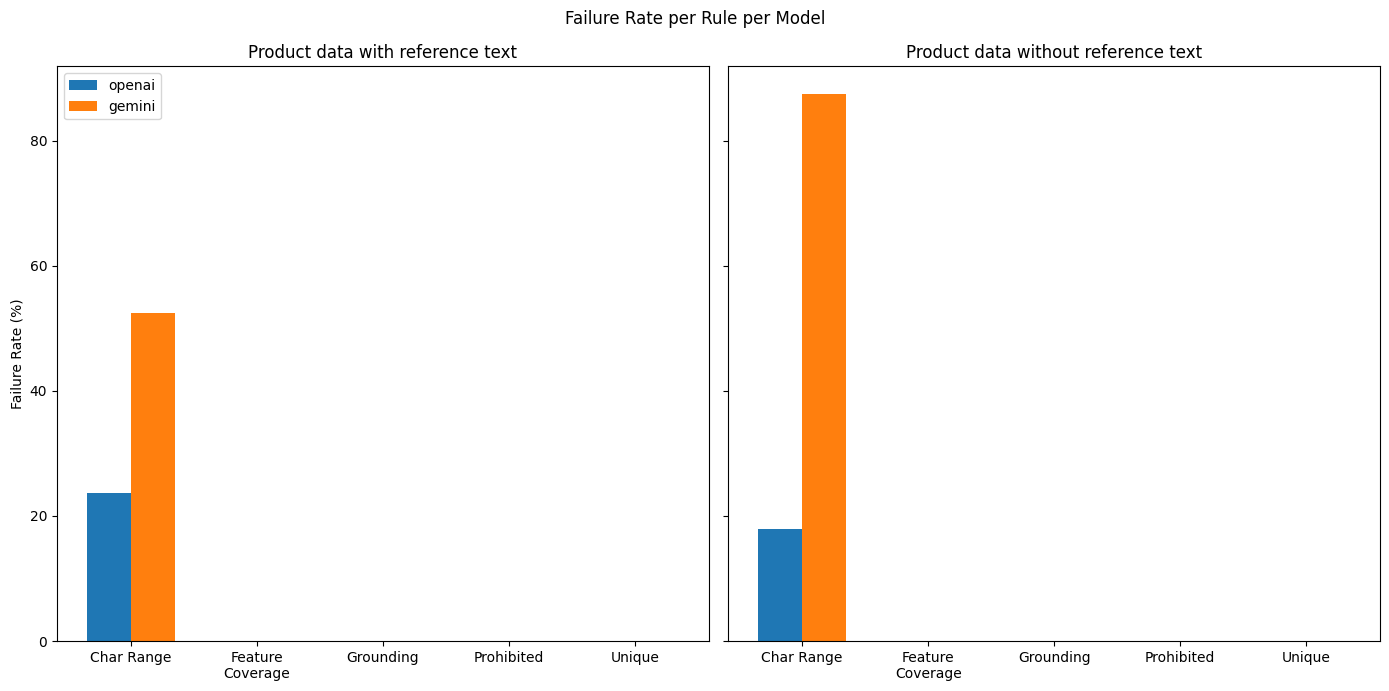

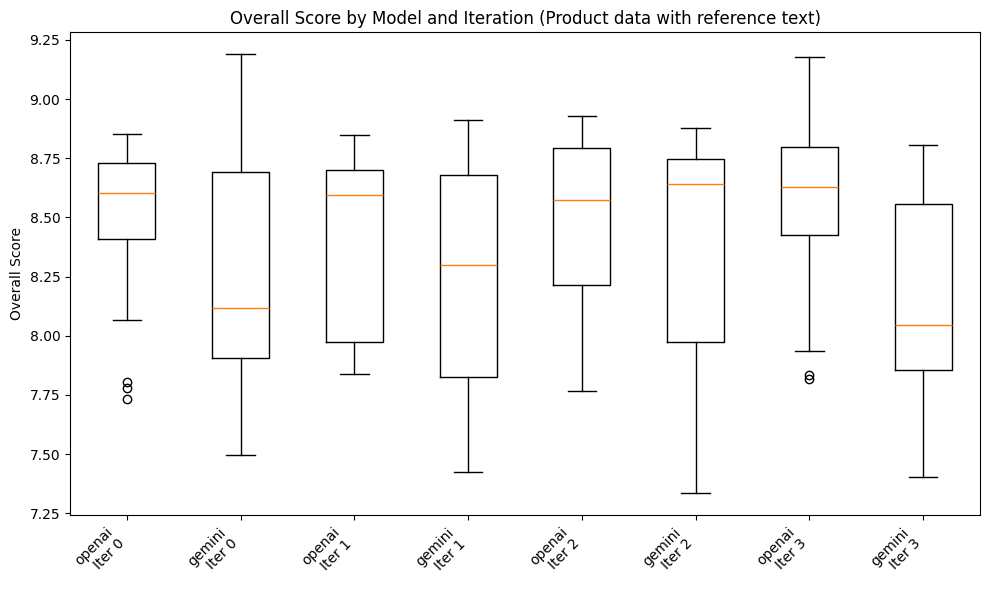

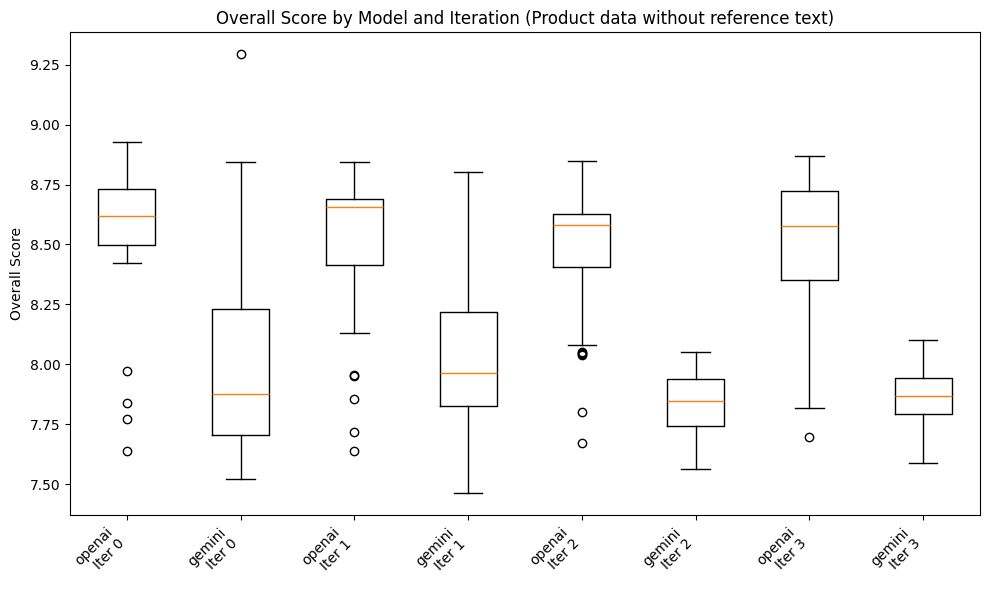

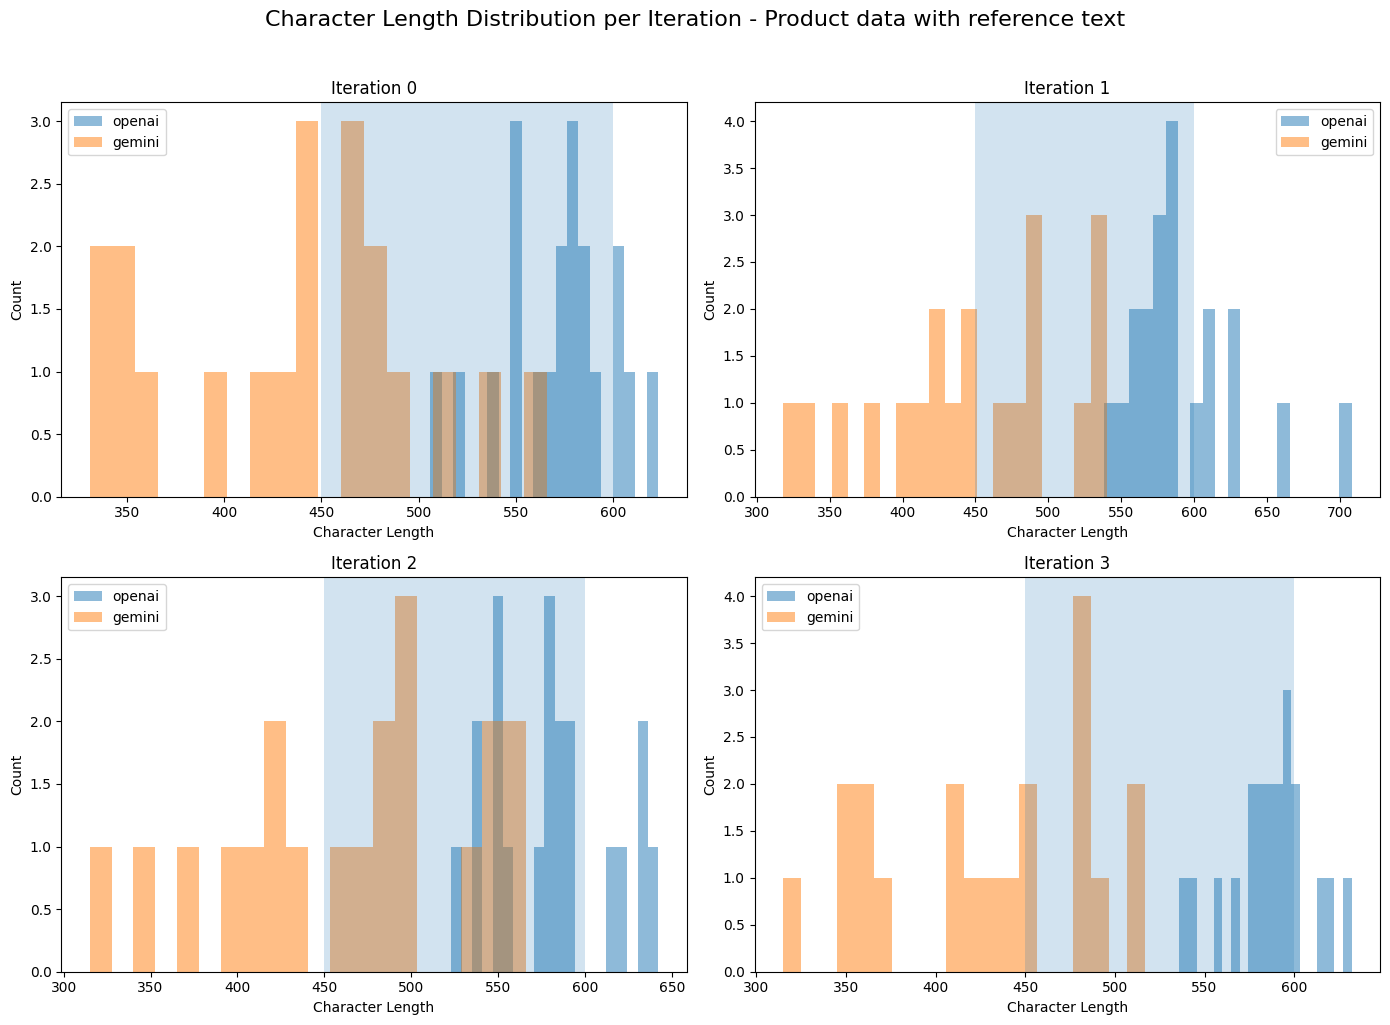

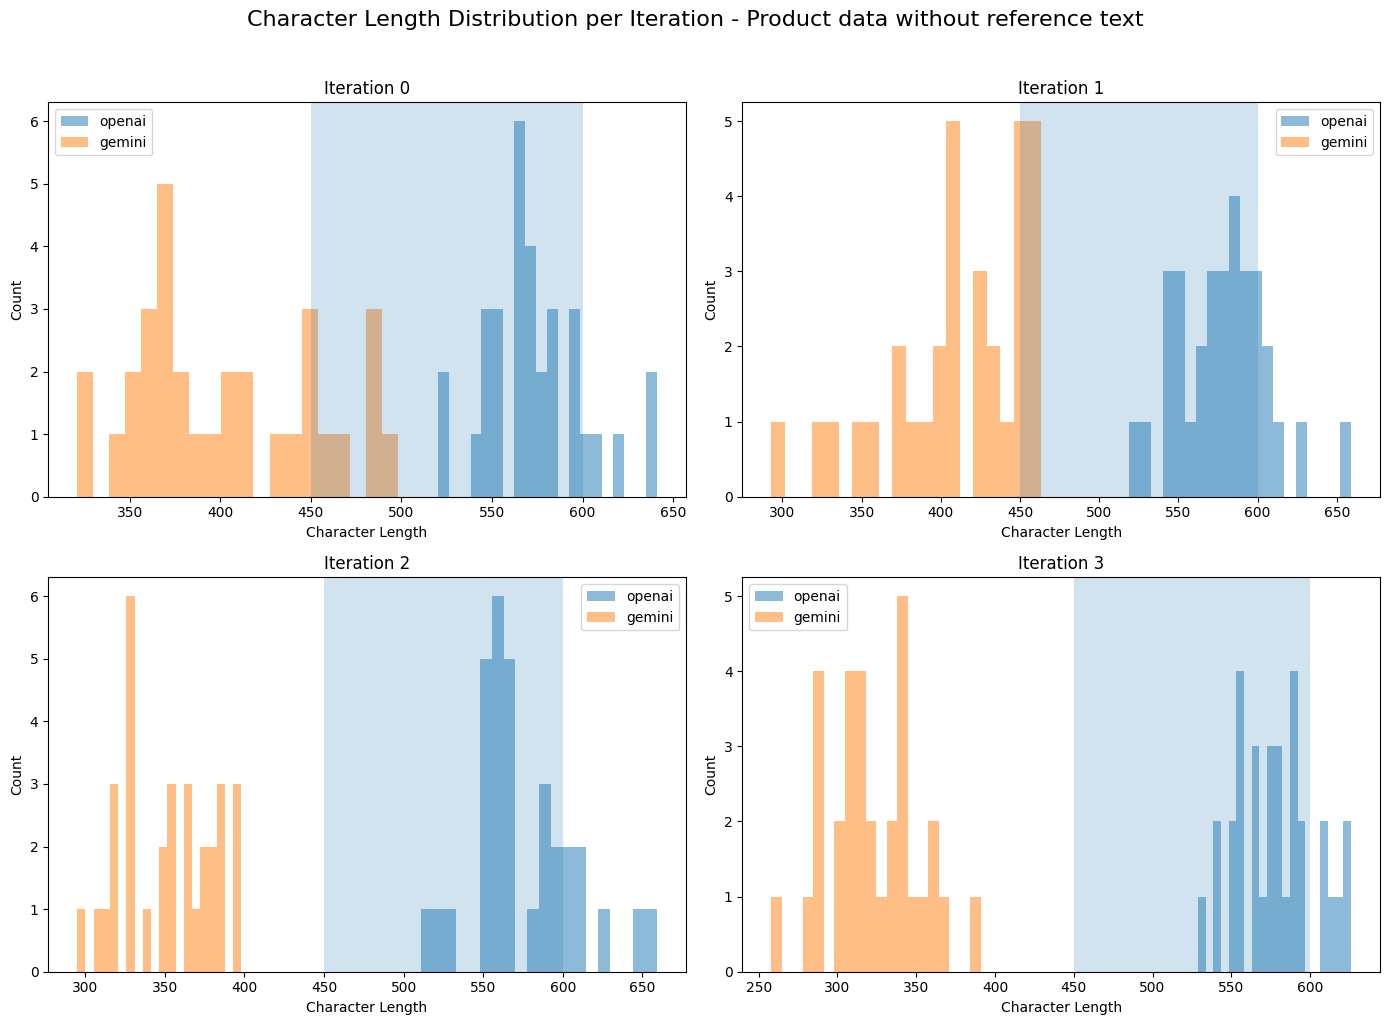

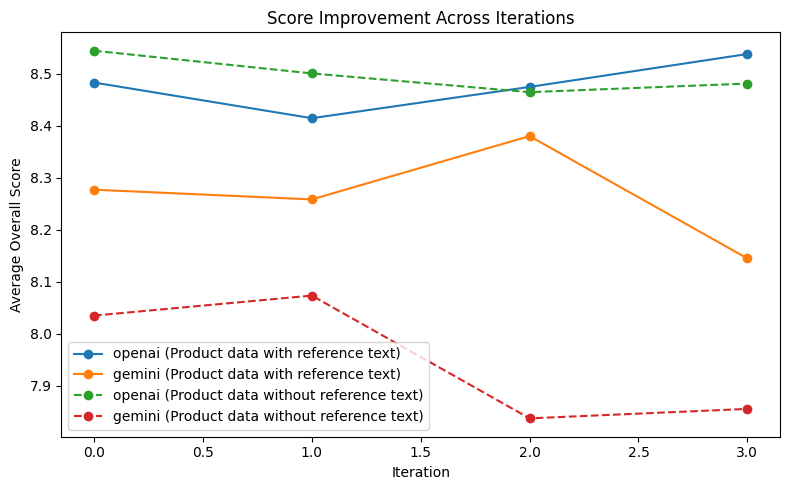

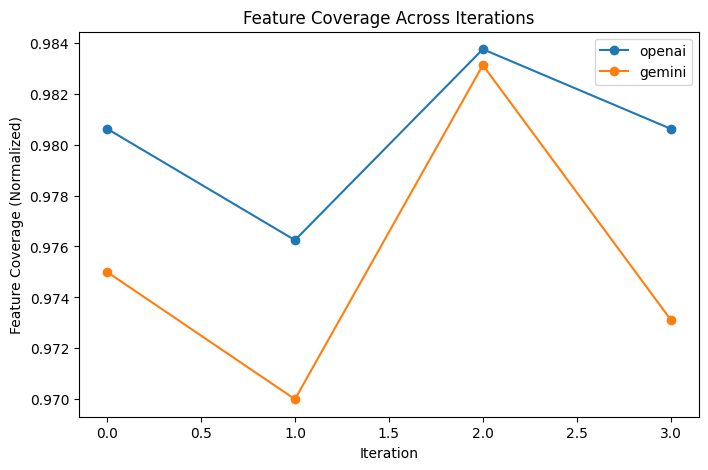

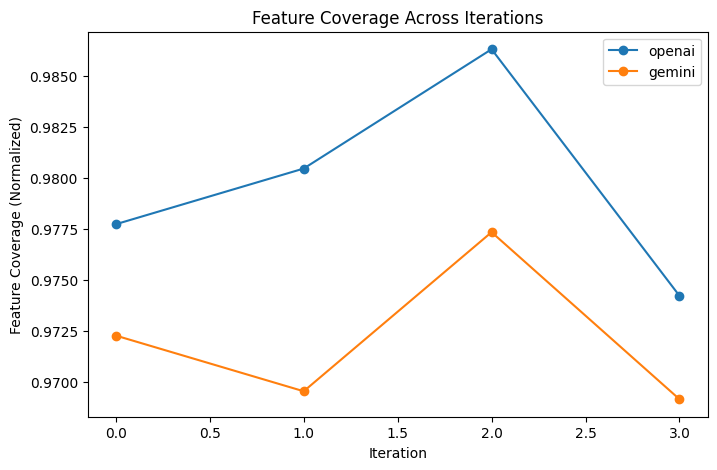

In [35]:

plot_failure_rates_combined(df_with, df_without)

# ============================
# BOX PLOTS
# ============================
plot_boxplots(df_with, dataset_name="Product data with reference text")
plot_boxplots(df_without, dataset_name="Product data without reference text")


# ============================
# LENGTH HISTOGRAM
# ============================
plot_length_hist_by_iteration(df_with, name="Product data with reference text")
plot_length_hist_by_iteration(df_without, name="Product data without reference text")


# ============================
# ITERATION CURVE
# ============================
plot_iteration_curve(df_with, df_without)

# ============================
# FEATURE COVERAGE TREND
# ============================
plot_feature_coverage(df_with)
plot_feature_coverage(df_without)


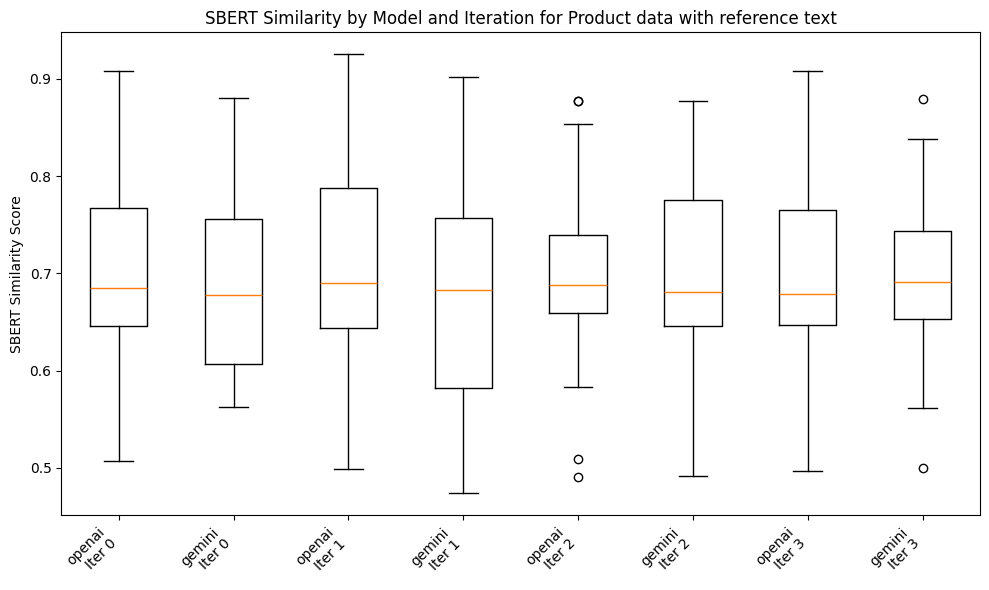

In [23]:
def plot_sbert_boxplot_by_iteration(df):
    iterations = sorted(df['iteration'].unique())
    models = df['model'].unique()

    fig, ax = plt.subplots(figsize=(10, 6))
    data, labels = [], []

    for it in iterations:
        for model in models:
            subset = df[(df['iteration'] == it) & (df['model'] == model)]
            data.append(subset['sbert'])
            labels.append(f"{model}\nIter {it}")

    ax.boxplot(data)
    ax.set_title("SBERT Similarity by Model and Iteration for Product data with reference text")
    ax.set_ylabel("SBERT Similarity Score")
    ax.set_xticklabels(labels, rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


plot_sbert_boxplot_by_iteration(df_with)
